<a href="https://colab.research.google.com/github/WRFitch/fyp/blob/main/src/fyp_model_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing
A notebook for testing an exported model. Ideally, this can be considered a part of a model evaluation pipeline, in which a model can be evaluated in greater depth. 

## Setup

### Notebook Setup 

In [5]:
!pip uninstall -y fastai
!pip install -U --no-cache-dir fastai

Uninstalling fastai-1.0.61:
  Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 194kB 6.7MB/s 
     |████████████████████████████████| 776.8MB 1.4MB/s 
     |████████████████████████████████| 61kB 45.2MB/s 
     |████████████████████████████████| 12.8MB 47.8MB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled torchvision-0.9.0+cu101


In [6]:
from fastai.vision.all import *
from google.colab import drive
#from scipy import stats
from sklearn.metrics import mean_squared_error

import numpy as np 
import os 
import pandas as pd

drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%rm -rf /content/fyp/

In [ ]:
# Import fyputil library
%cd /content
!git clone https://github.com/WRFitch/fyp.git
%cd fyp/src/fyputil
import constants as c
import fyp_utils as fyputil
%cd /content

### Data Setup 

In [7]:
# Add a dummy label script to fool fastai into letting us import the model. 
# We're not going to train the model further, so this is fine. 
def getGhgsAsArr(img_path):
  return np.array()

def normGhgDf(ghg_df):
  for band in c.ghg_bands:
    max = ghg_df[band].max()
    min = ghg_df[band].min()
    ghg_df[band] = ghg_df[band].apply(lambda x: (x-min)/(max-min) * 100)
  return ghg_df


In [ ]:
ghg_df = pd.read_csv(c.ghg_csv)
dnorm_ghg_df = pd.read_csv(c.ghg_csv)
ghg_df = normGhgDf(ghg_df)
ghg_df

In [ ]:
err_headers = [c.lon, c.lat] + c.ghg_bands
errors = pd.DataFrame(columns = err_headers)
errors.iloc[0:1]

In [14]:
def getGhgsAsArr(img_path):
  return fyputil.getGhgsAsArr(img_path, ghg_df)

def imgIsInDf(path):
  return fyputil.imgIsInDf(path, ghg_df)

def getGhgImgs(path):
  return get_image_files(path).filter(imgIsInDf)

ghg_block = DataBlock(
    blocks = (ImageBlock, RegressionBlock),
    get_items = getGhgImgs,
    get_y = getGhgsAsArr,
    item_tfms = Resize(460), 
    batch_tfms = aug_transforms(size=224, max_warp=0.05, max_zoom=1.0, max_rotate=45),
    splitter  = RandomSplitter()
)

ghg_dl = ghg_block.dataloaders(c.big_png_dir)

# Selecting Optimal Model

In [43]:
def validateModel(model):
  # Dumb & easy method of splitting data so I don't have to analyse every image 
  # every time I want to smell test something. 
  mod = 0 
  test_errs = pd.DataFrame(columns = err_headers)
  for filename in os.listdir(c.big_png_dir):
    file_ghgs = fyputil.getGhgs(filename, ghg_df)
    if file_ghgs == None: continue
    if mod % 100 == 0:
      #print(f"predicting ghg gases at {filename}")
      coords = fyputil.getCoords(filename) 
      prediction = model.predict(f"{c.big_png_dir}/{filename}")[0]
      diffs = [pred - act for pred, act in zip(prediction, file_ghgs)]
      test_errs.loc[len(test_errs)] = list(coords) + diffs
    mod += 1 
  
  rtnval = []
  for col in err_headers[2:]:
    test_errs[col].apply(lambda x: x ** 2)
    rtnval.append(test_errs[col].mean() ** .5)

  return rtnval

#model = load_learner("/content/drive/MyDrive//models/mrghg_180221_opts.pkl")
#for pred in validateModel(model):
#  print(pred)

In [ ]:
for root, _, files in os.walk(c.model_dir, topdown=True):
    for name in files:
      try:
        full_path = os.path.join(root, name)
        test_learner = load_learner(full_path)
      except Exception:
        print(Exception)
        print("model appears to have died. skipping... ")
        continue

      print(full_path)
      errs = validateModel(test_learner)
      print(errs)


/content/drive/MyDrive//models/resnet152_MRGHG_Demo1.pkl


## Testing

### Test model against existing data 

In [ ]:
# Dumb & easy method of splitting data so I don't have to analyse every image 
# every time I want to smell test something. 
mod = 0 

for filename in os.listdir(big_png_dir):
  file_ghgs = fyputil.getGhgs(filename, ghg_df)
  if file_ghgs == None: continue
  if mod % 1 == 0:
    print(f"predicting ghg gases at {filename}")
    coords = fyputil.getCoords(filename) 
    prediction = model.predict(f"{big_png_dir}/{filename}")[0]

    diffs = [pred - act for pred, act in zip(prediction, file_ghgs)]
    errors.loc[len(errors)] = list(coords) + diffs

    print(tuple(coords))
    print(prediction)
    print(file_ghgs)
    print(diffs)
    print()
  mod += 1 



In [ ]:
errors 

In [ ]:
errors.to_csv(f"{c.data_dir}/big_errors_norm.csv")

### Basic stat testing 
- Data exploration 
- RMSE per GHG
- Extract outliers & view images 

In [ ]:
errors = pd.read_csv(f"{c.data_dir}/errors_norm.csv")

In [ ]:
model_stats = pd.DataFrame(columns = ["stat"] + c.ghg_bands)

In [ ]:
def getRmse(series): 
  return np.sqrt(np.mean(series**2))

In [ ]:
# Define aggregate metrics 
# TODO remove multiple iterations through errors, improve bigO 
means = [errors[ghg].mean() for ghg in c.ghg_bands ]
stdevs = [errors[ghg].std() for ghg in c.ghg_bands ]
rmse = [getRmse(errors[ghg]) for ghg in c.ghg_bands ]
mae = [errors[ghg].abs().mean() for ghg in c.ghg_bands ]

model_stats.loc[1] = ["Mean"] + means
model_stats.loc[2] = ["Standard Deviation"] + stdevs 
model_stats.loc[3] = ["RMSE"] + rmse
model_stats.loc[4] = ["MAE"] + mae

In [ ]:
model_stats

#### Plot raw stats 

In [ ]:
# Merge ghg and recalculate predictions 
errcols = [f"{ghg}_err" for ghg in c.ghg_bands]
combi_df = ghg_df.merge(errors, how="inner", on=[c.lon, c.lat], suffixes=("_orig", "_err"))
for ghg in c.ghg_bands:
  combi_df[f"{ghg}_pred"] = combi_df[f"{ghg}_orig"] + combi_df[f"{ghg}_err"]

combi_df["errsum"] = combi_df[errcols].sum(axis=1)
combi_df["errabs"] = combi_df[errcols].abs().sum(axis=1)

In [ ]:
combi_df

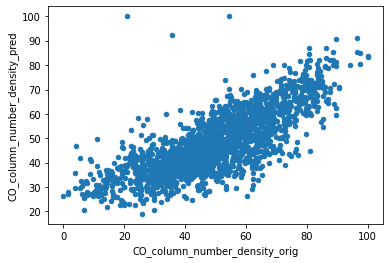

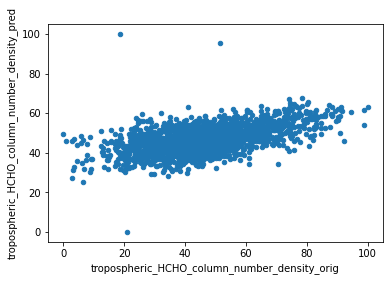

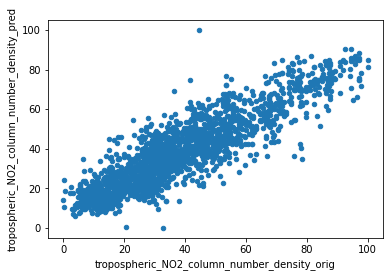

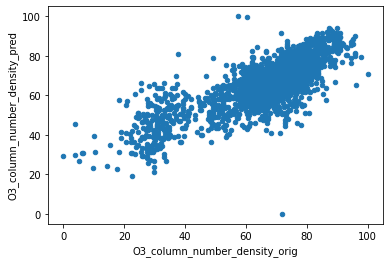

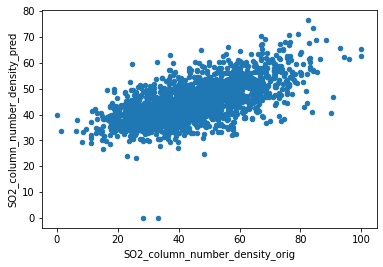

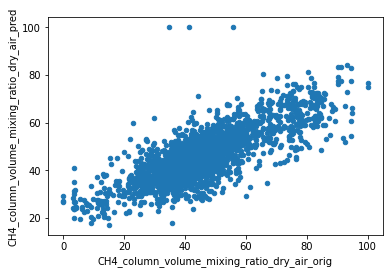

In [ ]:
for ghg in c.ghg_bands:
  combi_df.plot(x = f"{ghg}_orig", y = f"{ghg}_pred", kind = "scatter")
  plt.show()

### Find and process Outliers 
- Percentile 
  - 1.5*IQR for weak outliers
  - 3*IQR for strong outliers
- Linear regression 
- Standard deviation +- 2 (or 3) 
- Normal probability plot 



In [ ]:
# Individual outlier bands 
outliers = []
for ghg in c.ghg_bands:
  ghg_outliers = []
  q1 = combi_df[f"{ghg}_err"].quantile(0.25)
  q3 = combi_df[f"{ghg}_err"].quantile(0.75)
  iqr = q3 - q1
  lbound = q1 - 1.5*iqr
  ubound = q3 + 1.5*iqr
  ghg_outliers = combi_df.loc[(combi_df[f"{ghg}_err"] < lbound) | (combi_df[f"{ghg}_err"] > ubound)]
  outliers.append(ghg_outliers)


In [ ]:
all_outliers = pd.concat(outliers, join="inner").drop_duplicates()
all_outliers["errsum"] = all_outliers[errcols].abs().sum(axis=1)
all_outliers

In [ ]:
errcols = [f"{ghg}_err" for ghg in c.ghg_bands]
multiple_outliers = pd.concat(outliers, join="inner")
multiple_outliers = multiple_outliers[multiple_outliers.duplicated()]
multiple_outliers = multiple_outliers.drop_duplicates()
multiple_outliers["errsum"] = multiple_outliers[errcols].abs().sum(axis=1)
multiple_outliers

In [ ]:
multiple_outliers.nlargest(10, ['errsum'])

In [ ]:
# Show largest overpredictors 
for idx, row in combi_df.nlargest(50, ['errsum']).iterrows():
  coords = (row[c.lon], row[c.lat])
  print(coords)
  #print(row)
  img_path = fyputil.getFilepath(coords)
  display(Image.open(img_path))

In [ ]:
# show underpredictors
for idx, row in combi_df.nsmallest(50, ['errsum']).iterrows():
  coords = (row[c.lon], row[c.lat])
  print(coords)
  #print(row)
  img_path = fyputil.getFilepath(coords)
  display(Image.open(img_path))

In [ ]:
# show best predictions 
for idx, row in combi_df.nsmallest(50, ['errabs']).iterrows():
  coords = (row[c.lon], row[c.lat])
  print(coords)
  #print(row)
  img_path = fyputil.getFilepath(coords)
  display(Image.open(img_path))

### Sample images vs predictions 
what regions are easier to predict than others? 

create accuracy heatmap 

In [ ]:
# Show outliers 
for idx, row in combi_df.nlargest(20, [f"{c.SO2_band}_err"]).iterrows():
  if row[f"{c.SO2_band}_pred"] in [0, 100]: continue
  coords = (row[c.lon], row[c.lat])
  print(coords)
  print(row)
  img_path = fyputil.getFilepath(coords)
  display(Image.open(img_path))

###Testing against  other areas
Export and test areas from a few different places
- desert
- tundra
- creepy american robo-farms
- other major cities
  - manchester
  - paris
  - tokyo
  - new york 

### Plot errors on folium heatmap 

###Experiment with facet implementation
https://github.com/BCG-Gamma/facet

### bicubic/linear/non-grid-based interpolation